In [9]:
import sys, os
from charm.infer_halos_from_PM import get_model_interface
import matplotlib.pyplot as pl
import pathlib
import pickle as pk
import numpy as np
curr_path = pathlib.Path().absolute()
src_path = os.path.abspath(curr_path / "../charm/") 
%load_ext autoreload
%autoreload 2
%matplotlib inline




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the paths to trained model and config files:

In [10]:
run_config_massNtot_name = f'{src_path}/trained_configs/train_massNtot_config.yaml'
run_config_vel_name = f'{src_path}/trained_configs/train_vel_config.yaml'
trained_massmodel_name = f'{src_path}/trained_models/charm_model_massNtot_bestfit_v2.pth'
trained_velmodel_name = f'{src_path}/trained_models/charm_model_vel_bestfit_v2.pth'


Load the data and run the model:

In [11]:
# charm_data_ldir = '/mnt/home/spandey/ceph/test_CHARM_install/CHARM/charm_data/'
charm_data_ldir = 'PATH_TO_YOUR_CHARM_DATA'
z_REDSHIFT = '0.5'
test_LH_id = 3
LH_file = f'{charm_data_ldir}/latin_hypercube_params.txt'

LH_cosmo_val_all = np.loadtxt(LH_file)
cosmology_array = LH_cosmo_val_all[test_LH_id]


df_zg = pk.load(open(
    f'{charm_data_ldir}/density_HR_full_m_res_128_z={z_REDSHIFT}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb'))
rho_m_zg = df_zg['density_cic_unpad_combined']

df_load = pk.load(open(
    f'{charm_data_ldir}/velocity_HR_full_m_res_128_z={z_REDSHIFT}_nbatch_8_nfilter_3_ncnn_0.pk', 'rb')
    )
fac_norm_vel = 1.0
rho_m_vel_zg = df_load['velocity_cic_unpad_combined']/fac_norm_vel

model_interface = get_model_interface(run_config_massNtot_name=run_config_massNtot_name, run_config_vel_name=run_config_vel_name, 
                                    trained_massmodel_name=trained_massmodel_name, trained_velmodel_name=trained_velmodel_name)
pos_h_mock, lgMass_mock, vel_h_mock = model_interface.process_input_density(rho_m_zg=rho_m_zg, rho_m_vel_zg=rho_m_vel_zg,
                                    cosmology_array=cosmology_array,verbose=True)



Load the true halo catalog data for the same simulation. You can download this from the public Quijote website: https://quijote-simulations.readthedocs.io/en/latest/ 


In [15]:
isim = test_LH_id
snap_dir_base = '/mnt/home/fvillaescusa/ceph/Quijote/Halos/Rockstar/latin_hypercube_HR'
snapnum = 3
MAS     = 'NGP'  #mass-assigment scheme
verbose = False   #print information on progress
snapdir = snap_dir_base + '/' + str(isim)  #folder hosting the catalogue
rockstar = np.loadtxt(snapdir + '/out_' + str(snapnum) + '_pid.list')
with open(snapdir + '/out_' + str(snapnum) + '_pid.list', 'r') as f:
    lines = f.readlines()
header = lines[0].split()
# get the properties of the halos
pos_h_truth = rockstar[:,header.index('X'):header.index('Z')+1]
index_M = header.index('M200c')                    
mass_truth = rockstar[:,index_M]  #Halo masses in Msun/h
lgMass_truth = np.log10(mass_truth).astype(np.float32)
vel_h_truth = rockstar[:,header.index('VX'):header.index('VZ')+1]

indsel = np.where(mass_truth > 5e12)[0]
pos_h_truth = pos_h_truth[indsel]
vel_h_truth = vel_h_truth[indsel]
lgMass_truth = lgMass_truth[indsel]



/tmp/ipykernel_308613/4102284967.py:15: RuntimeWarning: divide by zero encountered in log10
  lgMass_truth = np.log10(mass_truth).astype(np.float32)


Compute the halo mass histogram:

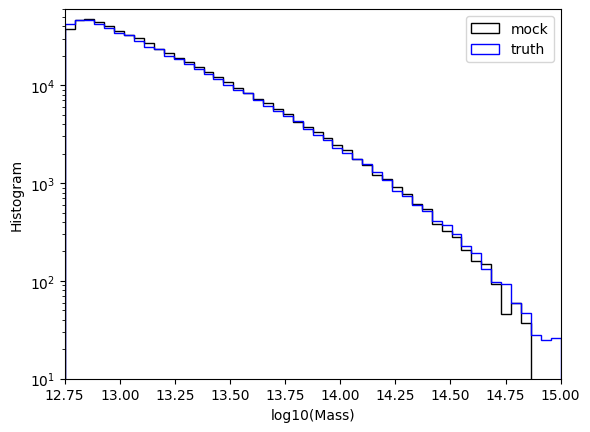

In [17]:
pl.figure()
_ = pl.hist(lgMass_mock, bins=50, histtype='step', color='k', range=(12.75, 15.0), label='mock')
_ = pl.hist(lgMass_truth, bins=50, histtype='step', color='b', range=(12.75, 15.0), label='truth')
pl.yscale('log')
pl.xlabel('log10(Mass)')
pl.ylabel('Histogram')
pl.xlim(12.75, 15.0)
pl.ylim(10, 6e4)
pl.legend()


Compute the real space power spectra:

Text(0.5, 1.0, 'Real space Pk, LH=3')

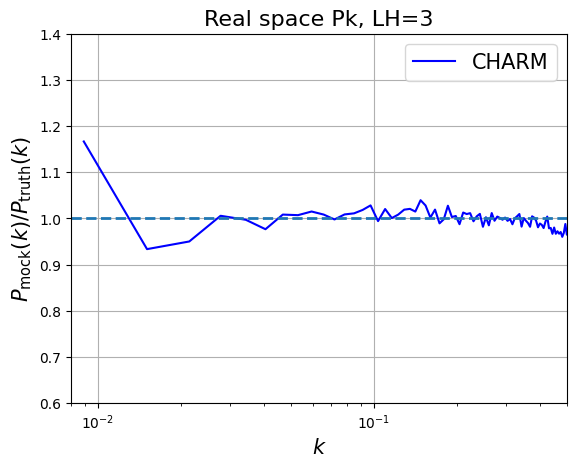

In [23]:
import Pk_library as PKL
import MAS_library as MASL
grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_truth.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_real = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_h_mock.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_real = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

pl.figure()
pl.plot(Pk_orig_real.k3D, Pk_charm_real.Pk[:,0]/Pk_orig_real.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Real space Pk, LH={test_LH_id}', size=16)




Calculate the redshift space power spectra:

In [26]:
import Pk_library as PKL
import MAS_library as MASL
import redshift_space_library as RSL

velx_orig = (vel_h_truth[:,0]).astype(np.float32)[:, None]
velx_charm = (vel_h_mock[:,0]).astype(np.float32)[:, None]

pos_rsd_orig = np.copy(pos_h_truth).astype(np.float32)
pos_rsd_charm = np.copy(np.ascontiguousarray(pos_h_mock)).astype(np.float32)

BoxSize = 1000.
Hubble = cosmology_array[2]*100.
redshift = 0.5
axis = 0


RSL.pos_redshift_space(pos_rsd_orig, velx_orig, BoxSize, Hubble, redshift, axis)
RSL.pos_redshift_space(pos_rsd_charm, velx_charm, BoxSize, Hubble, redshift, axis)

grid_Pk_full = 128
MAS = 'NGP'
threads = 10
mesh_orig = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsd_orig.astype(np.float32), mesh_orig, 1000., MAS)
mesh_orig /= np.mean(mesh_orig, dtype=np.float64);  mesh_orig -= 1.0
Pk_orig_rsd = PKL.Pk(mesh_orig, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)

mesh_charm = np.zeros((grid_Pk_full, grid_Pk_full, grid_Pk_full), dtype=np.float32)
MASL.MA(pos_rsd_charm.astype(np.float32), mesh_charm, 1000., MAS)
mesh_charm /= np.mean(mesh_charm, dtype=np.float64);  mesh_charm -= 1.0
Pk_charm_rsd = PKL.Pk(mesh_charm, 1000., axis=0, MAS=MAS, threads=threads, verbose=False)




Text(0.5, 1.0, 'Hexadecapole RSD Pk, LH=3')

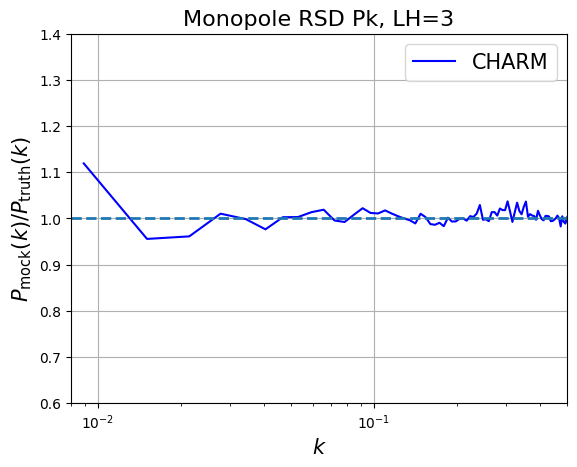

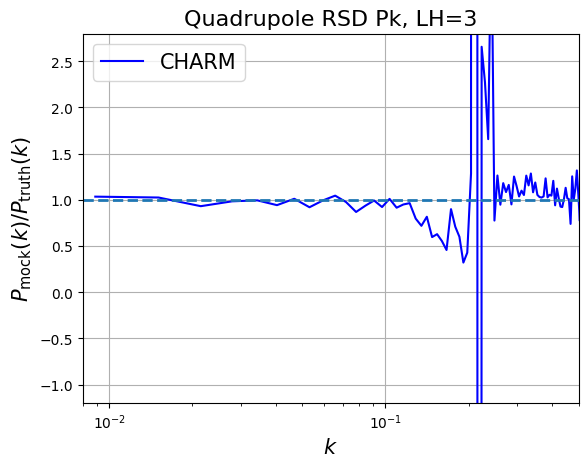

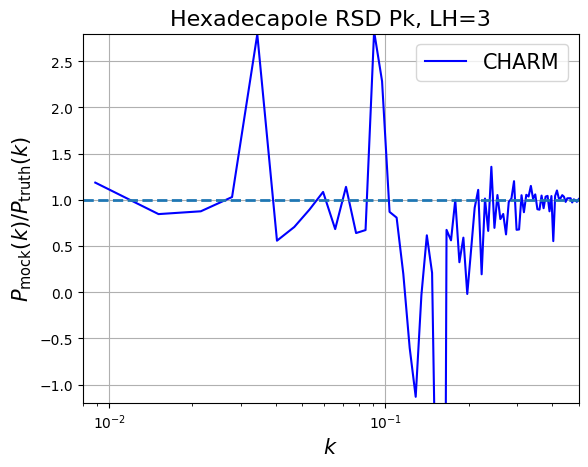

In [29]:
pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,0]/Pk_orig_rsd.Pk[:,0], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(0.6, 1.4)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Monopole RSD Pk, LH={test_LH_id}', size=16)
# pl.savefig(sdirf + f'NEW_monopole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,1]/Pk_orig_rsd.Pk[:,1], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Quadrupole RSD Pk, LH={test_LH_id}', size=16)
# pl.savefig(sdirf + f'NEW_Quadrupole_Pk.png', dpi=300,bbox_inches='tight')

pl.figure()
pl.plot(Pk_orig_rsd.k3D, Pk_charm_rsd.Pk[:,2]/Pk_orig_rsd.Pk[:,2], color='b', ls='-', alpha=1.0, label='CHARM')
pl.axhline(1.0, ls='--', lw=2.0)
pl.xscale('log')
pl.ylim(-1.2, 2.8)
pl.xlim(0.008, 0.5)
pl.xlabel(r'$k$', size=15)
pl.grid()
pl.legend(fontsize=15)
pl.ylabel(r'$P_{\rm mock}(k)/P_{\rm truth}(k)$', size=15)
pl.title(f'Hexadecapole RSD Pk, LH={test_LH_id}', size=16)
# pl.savefig(sdirf + f'NEW_Hexadecapole_Pk.png', dpi=300, bbox_inches='tight')







